# Plate recognition (HW)
![alt text](https://i.ytimg.com/vi/nmDiZGx5mqU/hqdefault.jpg)

**Deadline:** February 13th 23:55<br>
**Submission format:** .ipynb file with solution

In this homework you will try to recognize a Russian number plate. You can use any method for symbol recognition (CNN, some classic algorithm or Tesseract). But you are not allowed to use Tesseract for full number plate recognition, only use it to recognize single symbols! The main concept is:


1. Undistort the plate (you are given 4 corner points of the plate)
2. Perform segmentation
3. Recognize symbols
4. Concatenate recognized symbols

**Very important**: Your code needs to run! Hand in all files that are needed to run the code within a .zip-file and instructions to make it run! **Not running code parts will be awarded 0 points.**

**Plagiarism**, meaning identical code as in a different submission will lead to **0 points** for the whole submission! What is allowed is that you copy code if you use an existing model for recognizing the symbols - remember to reference to where you got the code from!

### Preparations

In [ ]:
# Import libraries
# all plots will be set directly below the code cell that produced it
!sudo apt-get update
!sudo apt-get install tesseract-ocr
!sudo apt-get install libtesseract-dev
!pip install pytesseract

%matplotlib inline
from matplotlib import pyplot as plt
# set inline plots size
plt.rcParams["figure.figsize"] = (15, 14) # (w, h)
import numpy as np
import pytesseract
import cv2

In [2]:
!wget "https://drive.google.com/uc?export=view&id=1vF8JiWOEkNd5NxtvQ1wfr8D-U3YGH3kf" -O russian_plate_recog.jpg
img_gray = cv2.imread("russian_plate_recog.jpg", cv2.IMREAD_GRAYSCALE)

--2020-09-07 17:20:13--  https://drive.google.com/uc?export=view&id=1vF8JiWOEkNd5NxtvQ1wfr8D-U3YGH3kf
Resolving drive.google.com (drive.google.com)... 172.217.212.100, 172.217.212.113, 172.217.212.139, ...
Connecting to drive.google.com (drive.google.com)|172.217.212.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vr1pin4at183v9kdhd0e7fse236i23hp/1599499200000/17396682441590382856/*/1vF8JiWOEkNd5NxtvQ1wfr8D-U3YGH3kf?e=view [following]
--2020-09-07 17:20:14--  https://doc-04-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vr1pin4at183v9kdhd0e7fse236i23hp/1599499200000/17396682441590382856/*/1vF8JiWOEkNd5NxtvQ1wfr8D-U3YGH3kf?e=view
Resolving doc-04-7s-docs.googleusercontent.com (doc-04-7s-docs.googleusercontent.com)... 172.217.212.132, 2607:f8b0:4001:c03::84
Connecting to doc-04-7s-docs.googleusercontent.com (doc-04-7s-doc

In [3]:
plate_points_1 = np.array([[1028, 874], [1184, 890], [1184, 924], [1027, 906]], np.int32)
plate_points_2 = np.array([[293, 714], [422, 719], [421, 749], [291, 743]], np.int32)

## Task 1: Draw borders around the number plate (10 points)

Draw the borders around the number plate and display the image with borders to visualize the region of interest! Try to get the tetragonal area as accurate as possible using the given plate points above! Also try to display colored borders on the otherwise greyscale image! Remember to draw on a copy of the image to leave the original image clean for the processing.

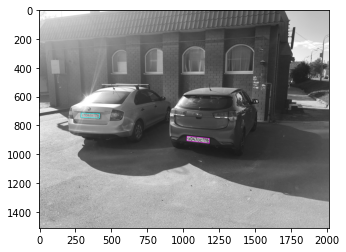

In [4]:
img_copy = img_gray.copy()
img_copy = cv2.cvtColor(img_copy,cv2.COLOR_GRAY2RGB)

cv2.line(img_copy, (1028,874), (1184,890),(255,0,255), 2)
cv2.line(img_copy, (1184,890), (1184,924),(255,0,255), 2)
cv2.line(img_copy, (1184,924), (1027,906),(255,0,255), 2)
cv2.line(img_copy, (1028,874), (1027,906),(255,0,255), 2)

cv2.line(img_copy, (293,714), (422,719),(0,255,255), 2)
cv2.line(img_copy, (422,719), (421,749),(0,255,255), 2)
cv2.line(img_copy, (421,749), (291,743),(0,255,255), 2)
cv2.line(img_copy, (293,714), (291,743),(0,255,255), 2)

plt.imshow(img_copy)

## Task 2: Undistort the plate (20 points)
Undistort the plate, so you receive an image that contains only the number plate. The OpenCV functions ```findHomography``` and ```warpPerspective``` might be helpful to get to the expected result!

Expected result:

![alt text](https://drive.google.com/uc?export=view&id=1xNKKcR-KYeqfwLKAHmAdetsFRHL9VOHY)

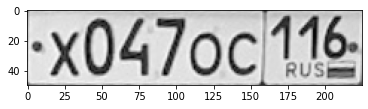

In [5]:
def get_plate(points, dist_corners):

  p = np.array(points)
  h, status = cv2.findHomography(p, dist_corners)
  result = cv2.warpPerspective(img_gray.copy(), h, (width, height))
  return result

height, width = 50, 225
dist_corners = np.array([[0, 0], [width, 0], [width, height], [0, height]])
result = get_plate(plate_points_1, dist_corners)
plt.imshow(result, cmap='gray')

## Task 3: Segmentation (20 points)
Segment the symbols so that you can draw bounding rectangles around them. For example, you can use morphological operations, ```findContours```, and ```minAreaRect```. Draw only rectangles around the symbols that are relevant for recognition!


Expected result:

![alt text](https://drive.google.com/uc?export=view&id=1nqP1g3VDctRfjBA6YV0A1OV3HF2FIEes)

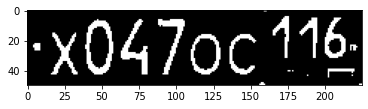

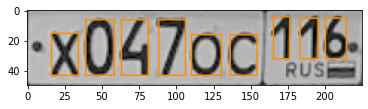

In [6]:
def draw_rectangles(result, img1=True):

  digits_img = result.copy()
  img_disp = cv2.cvtColor(result ,cv2.COLOR_GRAY2RGB)

  if img1 == False:
    thresh = cv2.GaussianBlur(digits_img,(11,5),1)
    thresh = cv2.adaptiveThreshold(thresh, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 51, 4)
  else:
    ret, thresh = cv2.threshold(digits_img, 70, 200, cv2.THRESH_BINARY_INV)
    
  kernel = np.ones((1,1), np.uint8)
  thresh = cv2.erode(thresh, kernel, iterations=1)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  height, width = thresh.shape
  min_x, min_y = width, height
  max_x = max_y = 0
  res_contours = []

  for c in contours:

      (x,y,w,h) = cv2.boundingRect(c)
      min_x, max_x = min(x, min_x), max(x+w, max_x)
      min_y, max_y = min(y, min_y), max(y+h, max_y)
      if h > 15 and h < 45:
        cv2.rectangle(img_disp, (x,y), (x+w,y+h), (255,140,0), 1)
        res_contours.append(c)
  
  return thresh, img_disp, res_contours


thresh, img_disp, res_contours = draw_rectangles(result)
plt.imshow(thresh, cmap='gray')
plt.figure()
plt.imshow(img_disp)

## Task 4: Recognition (30 points)

Use any method/library to recognize the letters, of which you found the image regions in the previous step. For example, a CNN can help you to recognize letters. You can use any CNN model that you find on the internet, or even train your own. The EMNIST (Extended MNIST) dataset may be helpful. Remember to include files/instructions into the submission!

Symbols ```O``` and ```0``` are hard to distinct and will lead to no point reduction. Also ```1``` and ```7``` might be harder to distinguish and will only lead to a small reduction of points.

Expected result:

![alt text](https://drive.google.com/uc?export=view&id=1gb5xIGBTAadyqcrZzNC0I4VM3KAhjkF7)

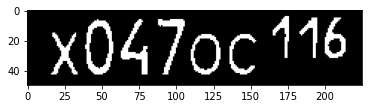

In [7]:
def recognize_digits(thresh, res_contours):

  stencil = np.zeros(thresh.shape).astype(thresh.dtype)
  cv2.fillPoly(stencil, res_contours, [255, 255, 255])
  output = cv2.bitwise_and(thresh, stencil)
  return output

output = recognize_digits(thresh, res_contours)
plt.imshow(output, cmap='gray')

## Task 5: Concatenation (5 points)
This should be the easiest part if you have done all previous steps:) Remember to get the order of symbols right!

Expected result: 
> **x0470c116**

In [8]:
def get_string(output):

    text = pytesseract.image_to_string(output)
    return text.replace(" ", "")

print(get_string(output))

x047oc116



## Task 6: Clean up your code (15 points)

Your code quality will be graded. You should clean up your code, try to make it readable and reusable. Only comment code parts that might need explaining, remove unnecessary comments and code parts that were only needed during development!

The required 15 points can be reached by basic cleaned-up, uncluttered code. Bonus points will be rewarded for encapsulating code into functions with meaningful parameters for reusability. This can also help you when trying to recognize the second number plate for more bonus points (see below!).

## Bonus task: Second Number Plate (15 bonus points)

Try to recognize the symbols in the second number plate! If the code for the first plate is not working well for the second plate, try to see, how to improve your code! The points will be rewarded depending on how much you need to change your code (is it generalizing well?) and how well the symbols have been recognized.

X106EK116



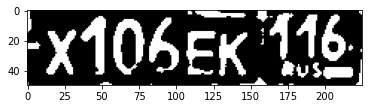

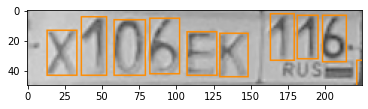

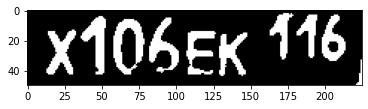

In [9]:
# Extracting the 2nd number plate
height, width = 50, 225
dist_corners = np.array([[0, 0], [width, 0], [width, height], [0, height]])
result = get_plate(plate_points_2, dist_corners)
plt.imshow(result, cmap='gray')

# Getting contours
thresh, img_disp, res_contours = draw_rectangles(result, False)
plt.imshow(thresh, cmap='gray')
plt.figure()
plt.imshow(img_disp)

# Cleaning image & recognizing String
output = recognize_digits(thresh, res_contours)
plt.figure()
plt.imshow(output, cmap='gray')

# printing the text
print(get_string(output))